In [1]:
import numpy as np
import pandas as pd
import sys
import os

try:
    if path:
        raise Exception('changed')
except:
    path = False
    sys.path.append('../')
    os.chdir('../')

from src.dataset import CarEvaluation, HayesRoth, Animals
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="white")

data_path = Path('./data')


%load_ext autoreload
%autoreload 2

In [2]:
from src.god_model_generator import god_model_generator
from src.data_generator import generate_data
from src.clustering import OrdinalClustering, univariate_em, compute_loglikelihood, compute_p_list
from src.bos_model_estimator import estimate_mu_pi_bos as estimate_mu_pi_bos, univariate_em
from src.aecm import AECM_BOS, AECM_GOD
from sklearn.metrics import adjusted_rand_score

## Run times experiments

In [3]:
# Multivariate data for run times comparison
n = 10000
n_cluster = 4
d = 10

seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

ms = [2, 3, 4, 5, 6, 7, 8, 9, 10]

model_type = "bos"

for seed in seeds:
    for m in ms:
        np.random.seed(seed)
        m = np.array([m] * d)
        mu = np.random.randint(np.ones(m.shape[0]), m + 1, (n_cluster, d))
        pi = np.random.random((n_cluster, d))

        # alpha = np.random.random(n_cluster)
        # alpha = alpha / np.sum(alpha)

        alpha = [1 / n_cluster] * n_cluster
        X, y = generate_data(n, p=d, n_cat=m, k=n_cluster, alpha=alpha, mu=mu, pi=pi, seed=seed, model=model_type)

        import pandas as pd

        df = pd.DataFrame(X, columns=[f'X{i}' for i in range(d)])
        df['y'] = y

        df.to_csv(data_path / f'comparison_curves/bos_data_n{n}_d{d}_m{np.max(m)}_k{n_cluster}_seed{seed}.csv', index=False)

In [4]:
# Univariate data for run times comparison
n = 10000
n_cluster = 1
d = 1

seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

ms = [2, 3, 4, 5, 6, 7, 8, 9, 10]

model_type = "bos"

for seed in seeds:
    for m in ms:
        np.random.seed(seed)
        m = np.array([m] * d)
        mu = np.random.randint(np.ones(m.shape[0]), m + 1, (n_cluster, d))
        pi = np.random.random((n_cluster, d))

        # alpha = np.random.random(n_cluster)
        # alpha = alpha / np.sum(alpha)

        alpha = [1 / n_cluster] * n_cluster
        X, y = generate_data(n, p=d, n_cat=m, k=n_cluster, alpha=alpha, mu=mu, pi=pi, seed=seed, model=model_type)

        import pandas as pd

        df = pd.DataFrame(X, columns=[f'X{i}' for i in range(d)])
        df['y'] = y

        df.to_csv(data_path / f'comparison_curves/bos_data_n{n}_d{d}_m{np.max(m)}_k{n_cluster}_seed{seed}.csv', index=False)

After running the ordinalClust R package, we import the data used and run the algorithms. The parameters used for the R package are the following:
- SEM iterations: 300
- Internal EM iterations: 200
- Initialization method: "kmeans"

Since the $\epsilon$ parameter is not known in the R package, we will take a very small value for the $\epsilon$ parameter in the Python implementation so that our estimation algorithnm stops because of the maximum number of iterations rather than the $\epsilon$ parameter. Moreover, our implementation does not have the internal EM iterations, so we will loop over the global iterations as many times as the SEM iterations in the R package.

In [51]:
import time

max_iter = 300
eps = -1 # will never stop

In [52]:
from tqdm import tqdm
# Multivariate


n = 10000
d = 10
n_cluster = 4
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

ms = [2, 3, 4, 5, 6, 7, 8, 9, 10]

df_run_times_multivariate = pd.DataFrame(columns=['m', 'run_time', 'n', 'd', 'n_cluster', 'seed'])
for seed in tqdm(seeds):
    run_times_multivariate = []
    for m in ms:
        df = pd.read_csv(data_path / f'comparison_curves/bos_data_n{n}_d{d}_m{m}_k{n_cluster}_seed{seed}.csv')
        X = df[[f'X{i}' for i in range(d)]].values
        y = df['y'].values

        start_time = time.time()

        clustering_bos = AECM_BOS(nb_clusters=n_cluster,
                            nb_features=d,
                            ms=np.array([m] * d),
                            data=X,
                            verbose=False,
                            seed=seed
                            )
        clustering_bos.fit(epsilon_aecm=eps, initialization='random', max_iter_aecm=max_iter)

        run_time = time.time() - start_time

        run_times_multivariate.append(run_time)

    df_run_times_multivariate = pd.concat([df_run_times_multivariate, pd.DataFrame({'m': ms, 'run_time': run_times_multivariate, 'n': np.ones(len(ms))*n, 'd': np.ones(len(ms))*d, 'n_cluster': np.ones(len(ms))*n_cluster, 'seed': np.ones(len(ms))*seed})])
df_run_times_multivariate.to_csv(data_path / f'comparison_curves/run_times_multivariate_us.csv', index=False)

  0%|          | 0/10 [00:00<?, ?it/s]

/var/folders/33/0_w6pc113h9fh86b1cqpzckr0000gn/T/ipykernel_86309/1532010446.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_run_times_multivariate = pd.concat([df_run_times_multivariate, pd.DataFrame({'m': ms, 'run_time': run_times_multivariate, 'n': np.ones(len(ms))*n, 'd': np.ones(len(ms))*d, 'n_cluster': np.ones(len(ms))*n_cluster, 'seed': np.ones(len(ms))*seed})])
100%|██████████| 10/10 [1:05:34<00:00, 393.44s/it]


In [53]:
from tqdm import tqdm
# Univariate

n = 10000
d = 1
n_cluster = 1
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

ms = [2, 3, 4, 5, 6, 7, 8, 9, 10]

df_run_times_univariate = pd.DataFrame(columns=['m', 'run_time', 'n', 'd', 'n_cluster', 'seed'])
for seed in tqdm(seeds):
    run_times_univariate = []
    for m in ms:
        df = pd.read_csv(data_path / f'comparison_curves/bos_data_n{n}_d{d}_m{m}_k{n_cluster}_seed{seed}.csv')
        X = df[[f'X{i}' for i in range(d)]].values
        y = df['y'].values

        start_time = time.time()

        clustering_bos = AECM_BOS(nb_clusters=n_cluster,
                            nb_features=d,
                            ms=np.array([m] * d),
                            data=X,
                            verbose=False,
                            seed=seed
                            )
        clustering_bos.fit(epsilon_aecm=eps, initialization='random', max_iter_aecm=max_iter)

        run_time = time.time() - start_time

        run_times_univariate.append(run_time)

    df_run_times_univariate = pd.concat([df_run_times_univariate, pd.DataFrame({'m': ms, 'run_time': run_times_univariate, 'n': np.ones(len(ms))*n, 'd': np.ones(len(ms))*d, 'n_cluster': np.ones(len(ms))*n_cluster, 'seed': np.ones(len(ms))*seed})])
df_run_times_univariate.to_csv(data_path / f'comparison_curves/run_times_multivariate_us.csv', index=False)

  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/33/0_w6pc113h9fh86b1cqpzckr0000gn/T/ipykernel_86309/1624055979.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_run_times_univariate = pd.concat([df_run_times_univariate, pd.DataFrame({'m': ms, 'run_time': run_times_univariate, 'n': np.ones(len(ms))*n, 'd': np.ones(len(ms))*d, 'n_cluster': np.ones(len(ms))*n_cluster, 'seed': np.ones(len(ms))*seed})])
100%|██████████| 10/10 [14:20<00:00, 86.01s/it]


In [49]:
max_iter = 300
eps = 1e-4 # will stop when convergence is reached or max_iter is reached

# Multivariate
n = 10000
d = 10
n_cluster = 4
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

ms = [2, 3, 4, 5, 6, 7, 8, 9, 10]

df_run_times_multivariate_epsilon = pd.DataFrame(columns=['m', 'run_time', 'n', 'd', 'n_cluster', 'seed'])
for seed in tqdm(seeds):
    run_times_multivariate = []
    for m in ms:
        df = pd.read_csv(data_path / f'comparison_curves/bos_data_n{n}_d{d}_m{m}_k{n_cluster}_seed{seed}.csv')
        X = df[[f'X{i}' for i in range(d)]].values
        y = df['y'].values

        start_time = time.time()

        clustering_bos = AECM_BOS(nb_clusters=n_cluster,
                            nb_features=d,
                            ms=np.array([m] * d),
                            data=X,
                            verbose=False,
                            seed=seed
                            )
        clustering_bos.fit(epsilon_aecm=eps, initialization='random', max_iter_aecm=max_iter)

        run_time = time.time() - start_time

        run_times_multivariate.append(run_time)

    df_run_times_multivariate_epsilon = pd.concat([df_run_times_multivariate_epsilon, pd.DataFrame({'m': ms, 'run_time': run_times_multivariate, 'n': np.ones(len(ms))*n, 'd': np.ones(len(ms))*d, 'n_cluster': np.ones(len(ms))*n_cluster, 'seed': np.ones(len(ms))*seed})])
df_run_times_multivariate_epsilon.to_csv(data_path / f'comparison_curves/run_times_multivariate_epsilon_us.csv', index=False)

# Univariate
n = 10000
d = 1
n_cluster = 1
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

ms = [2, 3, 4, 5, 6, 7, 8, 9, 10]

df_run_times_univariate_epsilon = pd.DataFrame(columns=['m', 'run_time', 'n', 'd', 'n_cluster', 'seed'])
for seed in tqdm(seeds):
    run_times_univariate = []
    for m in ms:
        df = pd.read_csv(data_path / f'comparison_curves/bos_data_n{n}_d{d}_m{m}_k{n_cluster}_seed{seed}.csv')
        X = df[[f'X{i}' for i in range(d)]].values
        y = df['y'].values

        start_time = time.time()

        clustering_bos = AECM_BOS(nb_clusters=n_cluster,
                            nb_features=d,
                            ms=np.array([m] * d),
                            data=X,
                            verbose=False,
                            seed=seed
                            )
        clustering_bos.fit(epsilon_aecm=eps, initialization='random', max_iter_aecm=max_iter)

        run_time = time.time() - start_time

        run_times_univariate.append(run_time)

    df_run_times_univariate_epsilon = pd.concat([df_run_times_univariate_epsilon, pd.DataFrame({'m': ms, 'run_time': run_times_univariate, 'n': np.ones(len(ms))*n, 'd': np.ones(len(ms))*d, 'n_cluster': np.ones(len(ms))*n_cluster, 'seed': np.ones(len(ms))*seed})])
df_run_times_univariate_epsilon.to_csv(data_path / f'comparison_curves/run_times_multivariate_epsilon_us.csv', index=False)

  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/33/0_w6pc113h9fh86b1cqpzckr0000gn/T/ipykernel_86309/2474686413.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_run_times_multivariate_epsilon = pd.concat([df_run_times_multivariate_epsilon, pd.DataFrame({'m': ms, 'run_time': run_times_multivariate, 'n': np.ones(len(ms))*n, 'd': np.ones(len(ms))*d, 'n_cluster': np.ones(len(ms))*n_cluster, 'seed': np.ones(len(ms))*seed})])
  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/33/0_w6pc113h9fh86b1cqpzckr0000gn/T/ipykernel_86309/2474686413.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the res

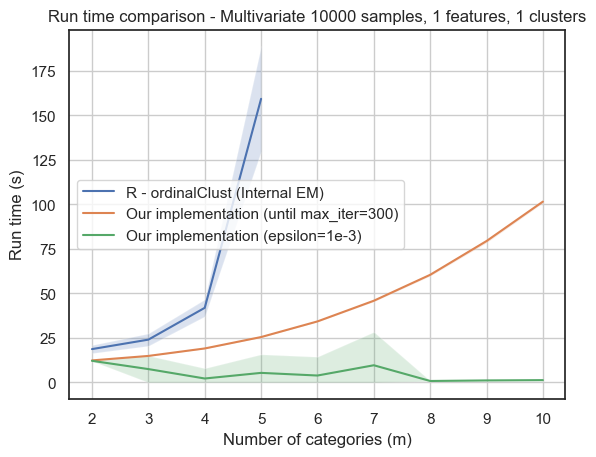

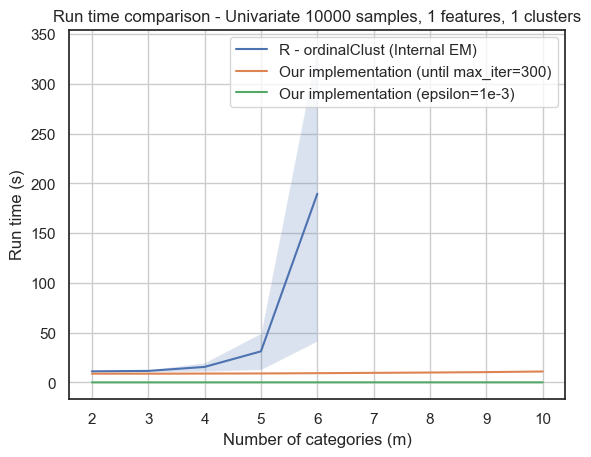

In [57]:
import seaborn as sns
sns.set_theme(style="white")

# Multivariate
df_run_times_multivariate_r = pd.read_csv(data_path / 'comparison_curves/run_times_multivariate_r.csv')
std_run_times_multivariate_r = df_run_times_multivariate_r.groupby("m").std()
run_times_multivariate_r = df_run_times_multivariate_r.groupby("m").mean()

std_run_times_multivariate = df_run_times_multivariate.groupby("m").std()
df_run_times_multivariate_grouped = df_run_times_multivariate.groupby("m").mean()
run_times_multivariate = df_run_times_multivariate_grouped["run_time"]

std_run_times_multivariate_epsilon = df_run_times_multivariate_epsilon.groupby("m").std()
df_run_times_multivariate_epsilon_grouped = df_run_times_multivariate_epsilon.groupby("m").mean()
run_times_multivariate_epsilon = df_run_times_multivariate_epsilon_grouped["run_time"]

plt.plot(run_times_multivariate_r.index, run_times_multivariate_r["run"], label='R - ordinalClust (Internal EM)')
plt.fill_between(run_times_multivariate_r.index, run_times_multivariate_r["run"] - std_run_times_multivariate_r["run"], run_times_multivariate_r["run"] + std_run_times_multivariate_r["run"], alpha=0.2)
plt.plot(ms, run_times_multivariate, label='Our implementation (until max_iter=300)')
plt.fill_between(ms, run_times_multivariate - std_run_times_multivariate["run_time"], run_times_multivariate + std_run_times_multivariate["run_time"], alpha=0.2)
plt.xlabel('Number of categories (m)')
plt.ylabel('Run time (s)')
plt.title(rf'Run time comparison - Multivariate {n} samples, {d} features, {n_cluster} clusters')
plt.grid()
plt.legend()

figures_path = Path("./report/python_figures/")
if not figures_path.exists():
    figures_path.mkdir(parents=True)
plt.savefig(figures_path / 'run_time_comparison_multivariate.png')
plt.plot(ms, run_times_multivariate_epsilon, label='Our implementation (epsilon=1e-3)')
plt.fill_between(ms, np.maximum(0, run_times_multivariate_epsilon - std_run_times_multivariate_epsilon["run_time"]), run_times_multivariate_epsilon + std_run_times_multivariate_epsilon["run_time"], alpha=0.2)
plt.legend()
plt.savefig(figures_path / 'run_time_comparison_multivariate_epsilon.png')
plt.show()

# Univariate
df_run_times_univariate_r = pd.read_csv(data_path / 'comparison_curves/run_times_univariate_r.csv')
std_run_times_univariate_r = df_run_times_univariate_r.groupby("m").std()
run_times_univariate_r = df_run_times_univariate_r.groupby("m").mean()

std_run_times_univariate = df_run_times_univariate.groupby("m").std()
df_run_times_univariate_grouped = df_run_times_univariate.groupby("m").mean()
run_times_univariate = df_run_times_univariate_grouped["run_time"]

std_run_times_univariate_epsilon = df_run_times_univariate_epsilon.groupby("m").std()
df_run_times_univariate_epsilon_grouped = df_run_times_univariate_epsilon.groupby("m").mean()
run_times_univariate_epsilon = df_run_times_univariate_epsilon_grouped["run_time"]

plt.plot(run_times_univariate_r.index, run_times_univariate_r["run"], label='R - ordinalClust (Internal EM)')
plt.fill_between(run_times_univariate_r.index, run_times_univariate_r["run"] - std_run_times_univariate_r["run"], run_times_univariate_r["run"] + std_run_times_univariate_r["run"], alpha=0.2)
plt.plot(ms, run_times_univariate, label='Our implementation (until max_iter=300)')
plt.fill_between(ms, run_times_univariate - std_run_times_univariate["run_time"], run_times_univariate + std_run_times_univariate["run_time"], alpha=0.2)
plt.xlabel('Number of categories (m)')
plt.ylabel('Run time (s)')
plt.title(rf'Run time comparison - Univariate {n} samples, {d} features, {n_cluster} clusters')
plt.grid()
plt.legend()

plt.savefig(figures_path / 'run_time_comparison_univariate.png')
plt.plot(ms, run_times_univariate_epsilon, label='Our implementation (epsilon=1e-3)')
plt.fill_between(ms, np.maximum(0, run_times_univariate_epsilon - std_run_times_univariate_epsilon["run_time"]), run_times_univariate_epsilon + std_run_times_univariate_epsilon["run_time"], alpha=0.2)
plt.legend()
plt.savefig(figures_path / 'run_time_comparison_univariate_epsilon.png')
plt.show()

## Clustering Performance on synthetic data

In [9]:
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs

data_models = ["bos", "god", "blobs", "gmm"]

scores = defaultdict(list)

def generate_data_gmm(n, means, covariances, weights, seed=0):
    np.random.seed(seed)
    n_cluster = len(weights)
    d = means.shape[1]
    X = np.zeros((n, d))
    y = np.zeros(n)
    for i in range(n):
        k = np.random.choice(n_cluster, p=weights)
        X[i] = np.random.multivariate_normal(means[k], covariances[k])
        y[i] = k
    return X, y

n = 10000
n_cluster = 4
ds = [4, 7, 10]
m_us = [4, 7, 10]

eps_aecm, n_iter = 1e-2, 200

seed = 3

for data_model in data_models:
    for d, m_u in zip(ds, m_us):
        scores[data_model].append({})
        scores[data_model][-1]["n"] = n
        scores[data_model][-1]["k"] = n_cluster
        scores[data_model][-1]["d"] = d
        scores[data_model][-1]["m"] = m_u
        print(f"Generating {data_model} data")
        np.random.seed(seed)

        if data_model in ["bos", "god", "gmm"]:
            m = np.array([m_u] * d)
            mu = np.random.randint(np.ones(m.shape[0]), m + 1, (n_cluster, d))
            pi = np.random.random((n_cluster, d))

            # alpha = [1 / n_cluster] * n_cluster
            alpha = np.random.random(n_cluster)
            alpha = alpha / np.sum(alpha)

            X, y = generate_data(n, p=d, n_cat=m, k=n_cluster, alpha=alpha, mu=mu, pi=pi, seed=seed, model=data_model)

        elif data_model == "blobs":
            X, y = make_blobs(n_samples=n, centers=n_cluster, center_box=(-5, 5), n_features=d, random_state=seed)
            y = y

            X = (np.floor(X) + np.abs(np.floor(X.min())) + 1).astype(int)
            m = np.array([np.max(X[:, i]) for i in range(d)])

        if data_model == "gmm":
            from sklearn.mixture import GaussianMixture

            gmm = GaussianMixture(n_components=n_cluster, covariance_type="full", random_state=seed)
            y = gmm.fit_predict(X)
            means = gmm.means_
            covariances = gmm.covariances_
            weights = gmm.weights_
            X, y = generate_data_gmm(n, means, covariances, weights, seed=seed)
            X = (np.floor(X) + np.abs(np.floor(X.min())) + 1).astype(int)
            X = np.clip(X, 1, m_u)
            m = np.array([np.max(X[:, i]) for i in range(d)])
        
        print(f"Fitting BOS model for {data_model} data...")
        clustering_bos = AECM_BOS(nb_clusters=n_cluster,
                            nb_features=d,
                            ms=m,
                            data=X,
                            verbose=False,
                            seed=seed
                            )
        clustering_bos.fit(epsilon_aecm=eps_aecm, initialization='kmeans', max_iter_aecm=n_iter)
        print(f"Finished fitting BOS model for {data_model} data")
        ari_bos = adjusted_rand_score(y, clustering_bos.labels)

        clustering_god = AECM_GOD(nb_clusters=n_cluster,
                            nb_features=d,
                            ms=m,
                            data=X,
                            verbose=False,
                            seed=seed
                            )
        print(f"Fitting GOD model for {data_model} data...")
        clustering_god.fit(epsilon_aecm=eps_aecm, initialization='kmeans', max_iter_aecm=n_iter)
        print(f"Finished fitting GOD model for {data_model} data")
        ari_god = adjusted_rand_score(y, clustering_god.labels)

        kmeans = KMeans(n_clusters=n_cluster, random_state=seed)
        print(f"Fitting KMeans model for {data_model} data...")
        kmeans.fit(X)
        print(f"Finished fitting KMeans model for {data_model} data")
        ari_kmeans = adjusted_rand_score(y, kmeans.labels_)

        gmm = GaussianMixture(n_components=n_cluster, covariance_type="full", random_state=seed)
        print(f"Fitting GMM model for {data_model} data...")
        y_gmm = gmm.fit_predict(X)
        print(f"Finished fitting GMM model for {data_model} data")
        ari_gmm = adjusted_rand_score(y, y_gmm)
        
        scores[data_model][-1]['ARI BOS'] = ari_bos
        scores[data_model][-1]['ARI GOD'] = ari_god
        scores[data_model][-1]['ARI KMeans'] = ari_kmeans
        scores[data_model][-1]['ARI GMM'] = ari_gmm

Generating bos data
Fitting BOS model for bos data...
Finished fitting BOS model for bos data
Fitting GOD model for bos data...
Finished fitting GOD model for bos data
Fitting KMeans model for bos data...


/Users/aliramlaoui/anaconda3/envs/ordinal_clustering/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Finished fitting KMeans model for bos data
Fitting GMM model for bos data...
Finished fitting GMM model for bos data
Generating bos data
Fitting BOS model for bos data...
Finished fitting BOS model for bos data
Fitting GOD model for bos data...
Finished fitting GOD model for bos data
Fitting KMeans model for bos data...


/Users/aliramlaoui/anaconda3/envs/ordinal_clustering/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Finished fitting KMeans model for bos data
Fitting GMM model for bos data...
Finished fitting GMM model for bos data
Generating bos data
Fitting BOS model for bos data...
Finished fitting BOS model for bos data
Fitting GOD model for bos data...
Finished fitting GOD model for bos data
Fitting KMeans model for bos data...


/Users/aliramlaoui/anaconda3/envs/ordinal_clustering/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Finished fitting KMeans model for bos data
Fitting GMM model for bos data...
Finished fitting GMM model for bos data
Generating god data
Fitting BOS model for god data...
Finished fitting BOS model for god data
Fitting GOD model for god data...
Finished fitting GOD model for god data
Fitting KMeans model for god data...


/Users/aliramlaoui/anaconda3/envs/ordinal_clustering/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Finished fitting KMeans model for god data
Fitting GMM model for god data...
Finished fitting GMM model for god data
Generating god data
Fitting BOS model for god data...
Finished fitting BOS model for god data
Fitting GOD model for god data...
Finished fitting GOD model for god data
Fitting KMeans model for god data...


/Users/aliramlaoui/anaconda3/envs/ordinal_clustering/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Finished fitting KMeans model for god data
Fitting GMM model for god data...
Finished fitting GMM model for god data
Generating god data
Fitting BOS model for god data...
Finished fitting BOS model for god data
Fitting GOD model for god data...
Finished fitting GOD model for god data
Fitting KMeans model for god data...


/Users/aliramlaoui/anaconda3/envs/ordinal_clustering/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Finished fitting KMeans model for god data
Fitting GMM model for god data...
Finished fitting GMM model for god data
Generating blobs data
Fitting BOS model for blobs data...
Finished fitting BOS model for blobs data
Fitting GOD model for blobs data...
Finished fitting GOD model for blobs data
Fitting KMeans model for blobs data...


/Users/aliramlaoui/anaconda3/envs/ordinal_clustering/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Finished fitting KMeans model for blobs data
Fitting GMM model for blobs data...
Finished fitting GMM model for blobs data
Generating blobs data
Fitting BOS model for blobs data...
Finished fitting BOS model for blobs data
Fitting GOD model for blobs data...
Finished fitting GOD model for blobs data
Fitting KMeans model for blobs data...


/Users/aliramlaoui/anaconda3/envs/ordinal_clustering/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Finished fitting KMeans model for blobs data
Fitting GMM model for blobs data...
Finished fitting GMM model for blobs data
Generating blobs data
Fitting BOS model for blobs data...
Finished fitting BOS model for blobs data
Fitting GOD model for blobs data...
Finished fitting GOD model for blobs data
Fitting KMeans model for blobs data...


/Users/aliramlaoui/anaconda3/envs/ordinal_clustering/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Finished fitting KMeans model for blobs data
Fitting GMM model for blobs data...
Finished fitting GMM model for blobs data
Generating gmm data
Fitting BOS model for gmm data...
Finished fitting BOS model for gmm data
Fitting GOD model for gmm data...
Finished fitting GOD model for gmm data
Fitting KMeans model for gmm data...


/Users/aliramlaoui/anaconda3/envs/ordinal_clustering/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Finished fitting KMeans model for gmm data
Fitting GMM model for gmm data...
Finished fitting GMM model for gmm data
Generating gmm data
Fitting BOS model for gmm data...
Finished fitting BOS model for gmm data
Fitting GOD model for gmm data...
Finished fitting GOD model for gmm data
Fitting KMeans model for gmm data...
Finished fitting KMeans model for gmm data
Fitting GMM model for gmm data...


/Users/aliramlaoui/anaconda3/envs/ordinal_clustering/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Finished fitting GMM model for gmm data
Generating gmm data
Fitting BOS model for gmm data...
Finished fitting BOS model for gmm data
Fitting GOD model for gmm data...
Finished fitting GOD model for gmm data
Fitting KMeans model for gmm data...


/Users/aliramlaoui/Library/CloudStorage/GoogleDrive-ramlaouiali@gmail.com/My Drive/Cours 3A/PGM/project/Ordinal-data-clustering/src/god_model_estimator.py:466: RuntimeWarning: divide by zero encountered in scalar divide
  return pi ** (m - 1) * evaluate_polynomial(u[mu - 1, x - 1], (1 - pi) / pi)
/Users/aliramlaoui/anaconda3/envs/ordinal_clustering/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Finished fitting KMeans model for gmm data
Fitting GMM model for gmm data...
Finished fitting GMM model for gmm data


In [10]:

for data_model in data_models:
    entries = []
    for score in scores[data_model]:
        entries.append({"data_model": data_model, **score, })

    df_scores = pd.DataFrame(entries)

    df_scores.columns = [
        "Data model", "n", "k", "d", "m", "ARI BOS", "ARI GOD", "ARI KMeans", "ARI GMM"
    ]

    df_scores = df_scores.groupby(['Data model', 'n', 'k', 'd', 'm']).mean()

    caption = f"Results of the experiments for the {data_model} data model when varying the number of categories m and the number of features d. The Adjusted Rand Index (ARI) is used to compare the clustering results with the true labels. The models used to cluster the data are BOS, GOD, KMeans and GMM."

    print(df_scores.to_latex(caption=caption, float_format="%.3f",
                                label="tab:results_god", escape=False,
                                position="H",
                                multicolumn_format="c",
                                ))

    df_scores.to_csv(data_path / f'synthetic/{data_model}_scores.csv', index=False)

\begin{table}[H]
\caption{Results of the experiments for the bos data model when varying the number of categories m and the number of features d. The Adjusted Rand Index (ARI) is used to compare the clustering results with the true labels. The models used to cluster the data are BOS, GOD, KMeans and GMM.}
\label{tab:results_god}
\begin{tabular}{lllllrrrr}
\toprule
 &  &  &  &  & ARI BOS & ARI GOD & ARI KMeans & ARI GMM \\
Data model & n & k & d & m &  &  &  &  \\
\midrule
\multirow[t]{3}{*}{bos} & \multirow[t]{3}{*}{10000} & \multirow[t]{3}{*}{4} & 4 & 4 & 0.389 & 0.367 & 0.189 & 0.192 \\
\cline{4-9}
 &  &  & 7 & 7 & 0.855 & 0.840 & 0.395 & 0.450 \\
\cline{4-9}
 &  &  & 10 & 10 & 0.972 & 0.963 & 0.691 & 0.580 \\
\cline{1-9} \cline{2-9} \cline{3-9} \cline{4-9}
\bottomrule
\end{tabular}
\end{table}

\begin{table}[H]
\caption{Results of the experiments for the god data model when varying the number of categories m and the number of features d. The Adjusted Rand Index (ARI) is used to comp

## Data visualization

#### BOS Model

/Users/aliramlaoui/anaconda3/envs/ordinal_clustering/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


ARI GOD: 0.3431041584841667
ARI BOS: 0.4461414541398887
ARI KMeans: 0.22111914215231038


/Users/aliramlaoui/anaconda3/envs/ordinal_clustering/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


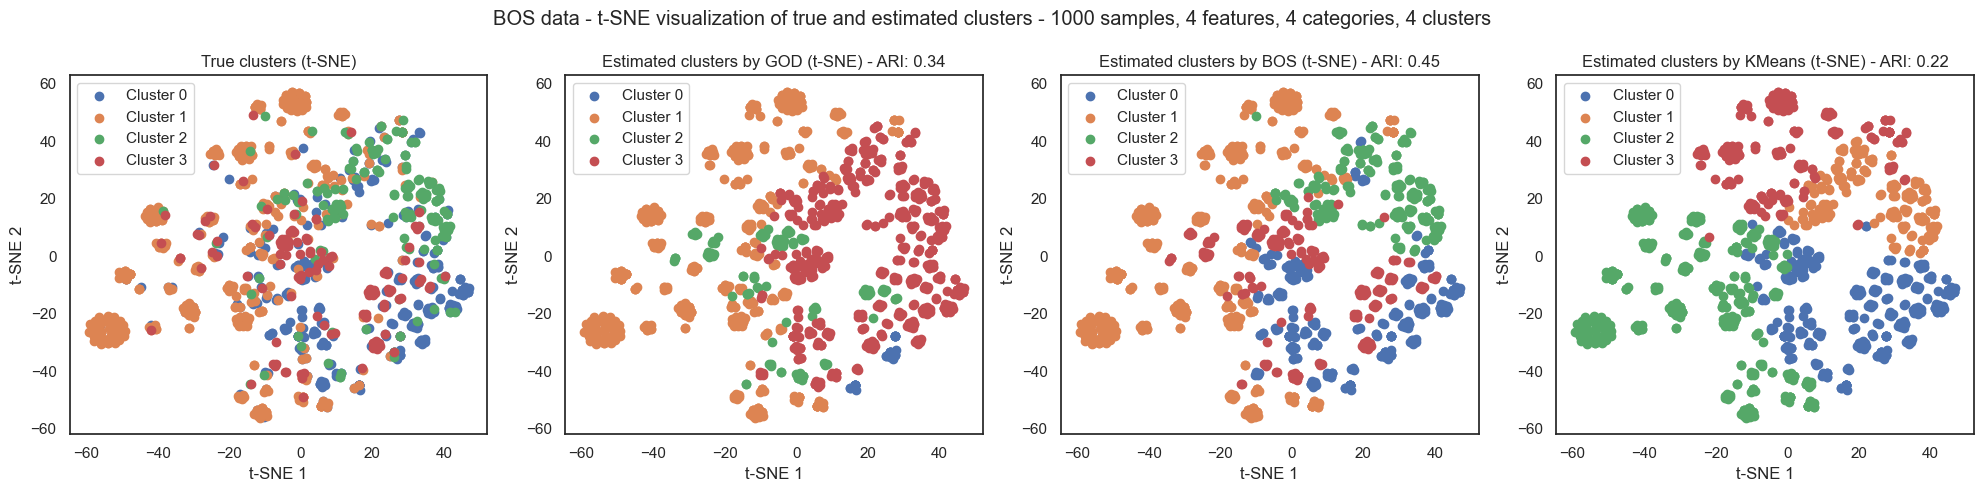

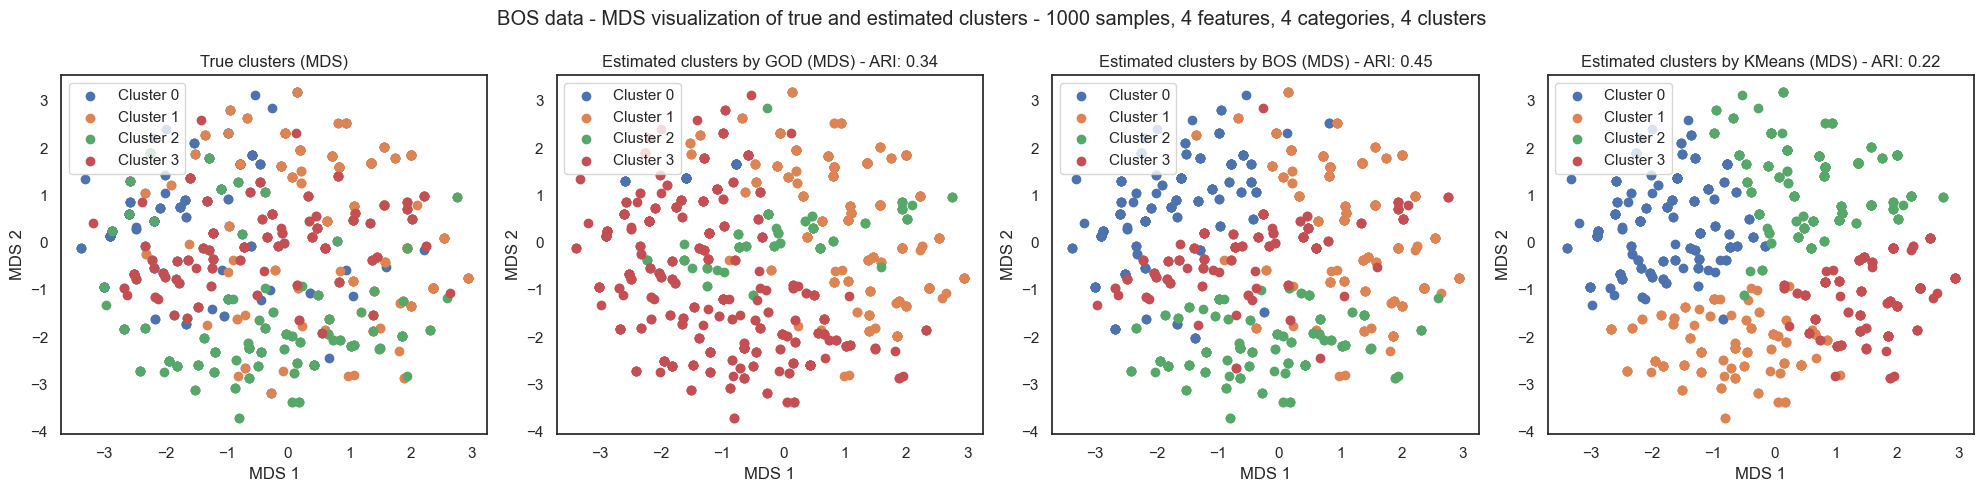

/Users/aliramlaoui/anaconda3/envs/ordinal_clustering/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


ARI GOD: 0.8460373145208107
ARI BOS: 0.8738320012286309
ARI KMeans: 0.41636905754722375


/Users/aliramlaoui/anaconda3/envs/ordinal_clustering/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


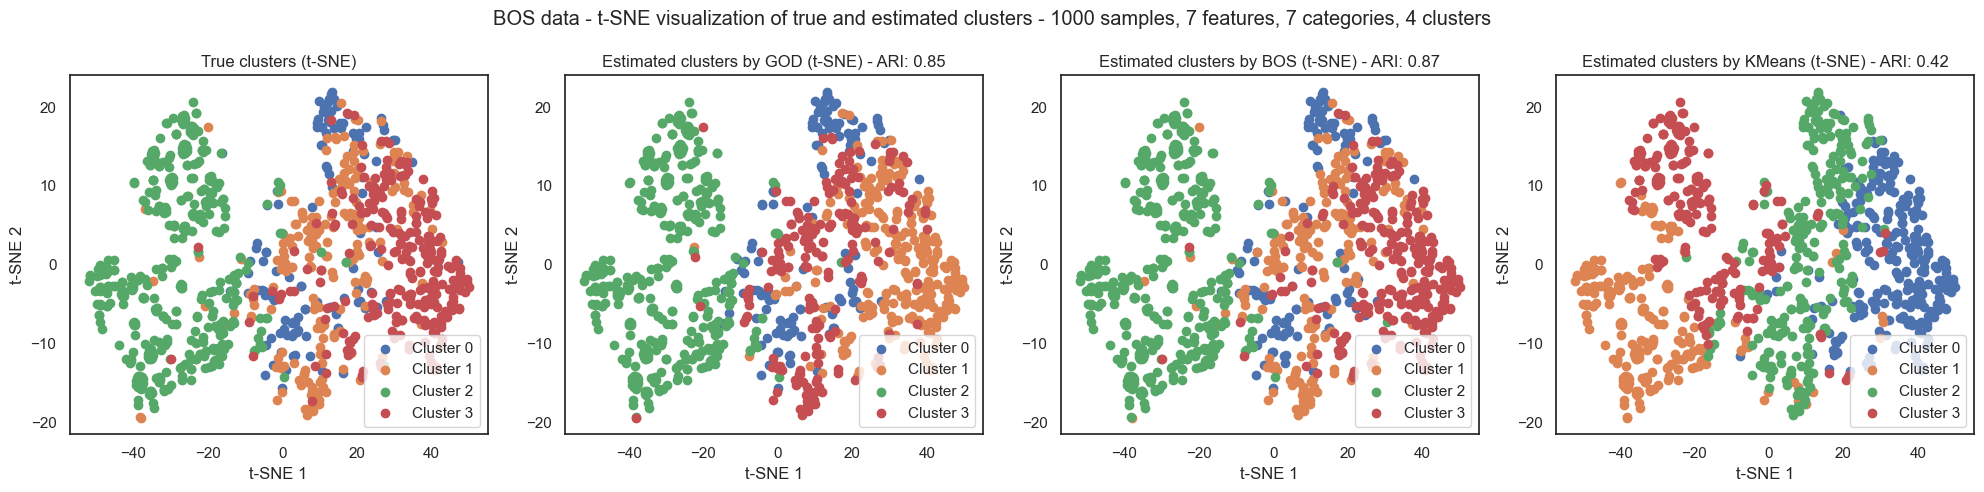

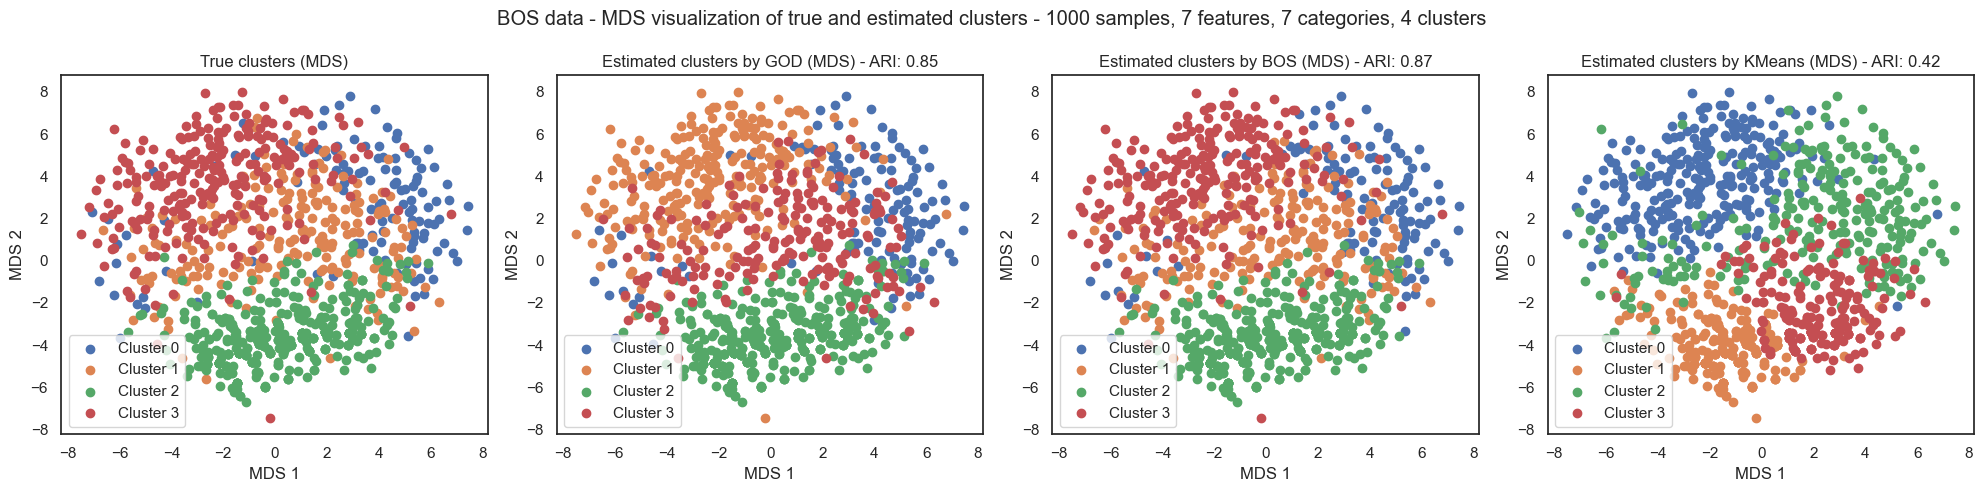

/Users/aliramlaoui/anaconda3/envs/ordinal_clustering/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


ARI GOD: 0.9470251844210313
ARI BOS: 0.9458232707626336
ARI KMeans: 0.6709027927119


/Users/aliramlaoui/anaconda3/envs/ordinal_clustering/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


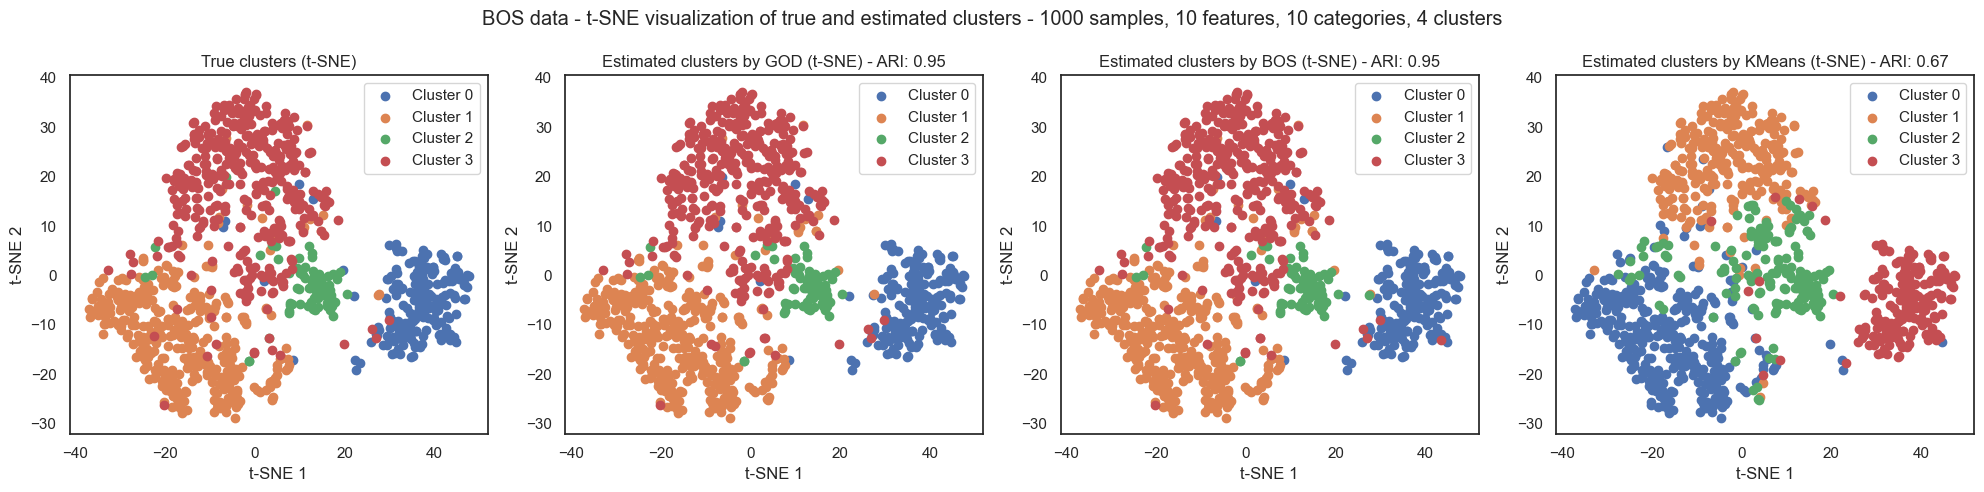

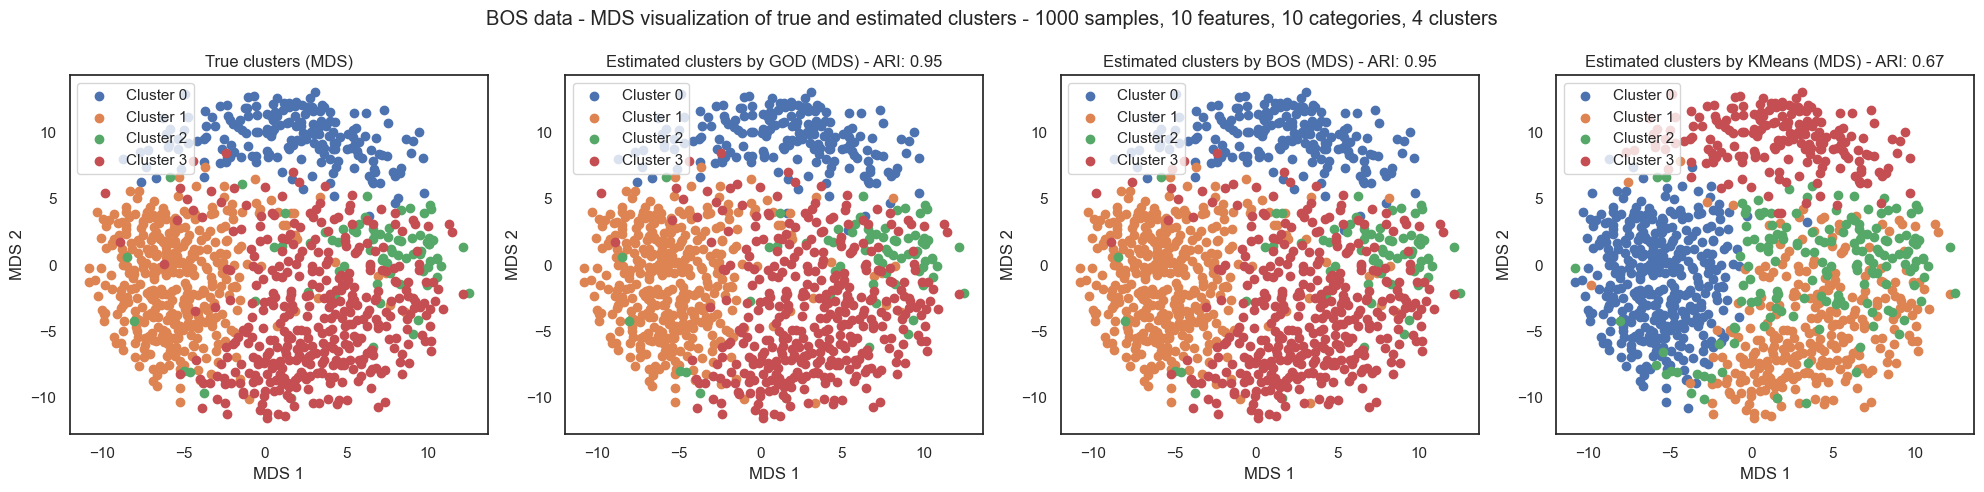

In [5]:
from sklearn.manifold import MDS, TSNE
from sklearn.cluster import KMeans

n = 1000
n_cluster = 4
ds = [4, 7, 10]
m_us = [4, 7, 10]

eps_aecm, n_iter = 1e-2, 200

seed = 3

data_model = "bos"

figures_path = Path("./report/python_figures/")

for d, m_u in zip(ds, m_us):
    fig_tsne, ax_tsne = plt.subplots(1, 4, figsize=(20, 5))
    fig_mds, ax_mds = plt.subplots(1, 4, figsize=(20, 5))

    np.random.seed(seed)
    m = np.array([m_u] * d)
    mu = np.random.randint(np.ones(m.shape[0]), m + 1, (n_cluster, d))
    pi = np.random.random((n_cluster, d))

    # alpha = [1 / n_cluster] * n_cluster
    alpha = np.random.random(n_cluster)
    alpha = alpha / np.sum(alpha)

    X, y = generate_data(n, p=d, n_cat=m, k=n_cluster, alpha=alpha, mu=mu, pi=pi, seed=seed, model=data_model)

    clustering_god = AECM_GOD(nb_clusters=n_cluster,
                        nb_features=d,
                        ms=m,
                        data=X,
                        verbose=False,
                        seed=seed
                        )

    clustering_bos = AECM_BOS(nb_clusters=n_cluster,
                        nb_features=d,
                        ms=m,
                        data=X,
                        verbose=False,
                        seed=seed
                        )
                        
    ll_list_god = clustering_god.fit(epsilon_aecm=eps_aecm, max_iter_aecm=n_iter)

    ll_list_bos = clustering_bos.fit(epsilon_aecm=eps_aecm, max_iter_aecm=n_iter)

    labels_god = clustering_god.labels

    labels_bos = clustering_bos.labels

    kmeans = KMeans(n_clusters=n_cluster, random_state=seed)
    kmeans.fit(X)
    labels_kmeans = kmeans.labels_

    print(f"ARI GOD: {adjusted_rand_score(y, labels_god)}")
    print(f"ARI BOS: {adjusted_rand_score(y, labels_bos)}")
    print(f"ARI KMeans: {adjusted_rand_score(y, labels_kmeans)}")

    tsne = TSNE(n_components=2)
    X_tsne = tsne.fit_transform(X)


    def plot_tsne_mds(ax, X, y, title, type='t-SNE'):
        for i in range(np.unique(y).shape[0]):
            ax.scatter(X[y == i, 0], X[y == i, 1], label=f'Cluster {i}')
        ax.legend()
        ax.set_title(title)
        ax.set_xlabel(f'{type} 1')
        ax.set_ylabel(f'{type} 2')
        return ax
    
    plot_tsne_mds(ax_tsne[0], X_tsne, y, 'True clusters (t-SNE)', type='t-SNE')
    plot_tsne_mds(ax_tsne[1], X_tsne, labels_god, f'Estimated clusters by GOD (t-SNE) - ARI: {np.round(adjusted_rand_score(y, labels_god), 2)}', type='t-SNE')
    plot_tsne_mds(ax_tsne[2], X_tsne, labels_bos, f'Estimated clusters by BOS (t-SNE) - ARI: {np.round(adjusted_rand_score(y, labels_bos), 2)}', type='t-SNE')
    plot_tsne_mds(ax_tsne[3], X_tsne, labels_kmeans, f'Estimated clusters by KMeans (t-SNE) - ARI: {np.round(adjusted_rand_score(y, labels_kmeans), 2)}', type='t-SNE')

    mds = MDS(n_components=2, metric=True)
    X_mds = mds.fit_transform(X)

    plot_tsne_mds(ax_mds[0], X_mds, y, 'True clusters (MDS)', type='MDS')
    plot_tsne_mds(ax_mds[1], X_mds, labels_god, f'Estimated clusters by GOD (MDS) - ARI: {np.round(adjusted_rand_score(y, labels_god), 2)}', type='MDS')
    plot_tsne_mds(ax_mds[2], X_mds, labels_bos, f'Estimated clusters by BOS (MDS) - ARI: {np.round(adjusted_rand_score(y, labels_bos), 2)}', type='MDS')
    plot_tsne_mds(ax_mds[3], X_mds, labels_kmeans, f'Estimated clusters by KMeans (MDS) - ARI: {np.round(adjusted_rand_score(y, labels_kmeans), 2)}', type='MDS')

    fig_tsne.suptitle(f"BOS data - t-SNE visualization of true and estimated clusters - {n} samples, {d} features, {m_u} categories, {n_cluster} clusters")
    fig_mds.suptitle(f"BOS data - MDS visualization of true and estimated clusters - {n} samples, {d} features, {m_u} categories, {n_cluster} clusters")

    fig_tsne.tight_layout()
    fig_mds.tight_layout()

    fig_tsne.savefig(figures_path / f'tsne_bos_n{n}_d{d}_m{m_u}_k{n_cluster}.png')
    fig_mds.savefig(figures_path / f'mds_bos_n{n}_d{d}_m{m_u}_k{n_cluster}.png')
    plt.show()

/Users/aliramlaoui/anaconda3/envs/ordinal_clustering/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


ARI GOD: 0.4709177585463877
ARI BOS: 0.3490324526876182
ARI KMeans: 0.2231356121706218


/Users/aliramlaoui/anaconda3/envs/ordinal_clustering/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


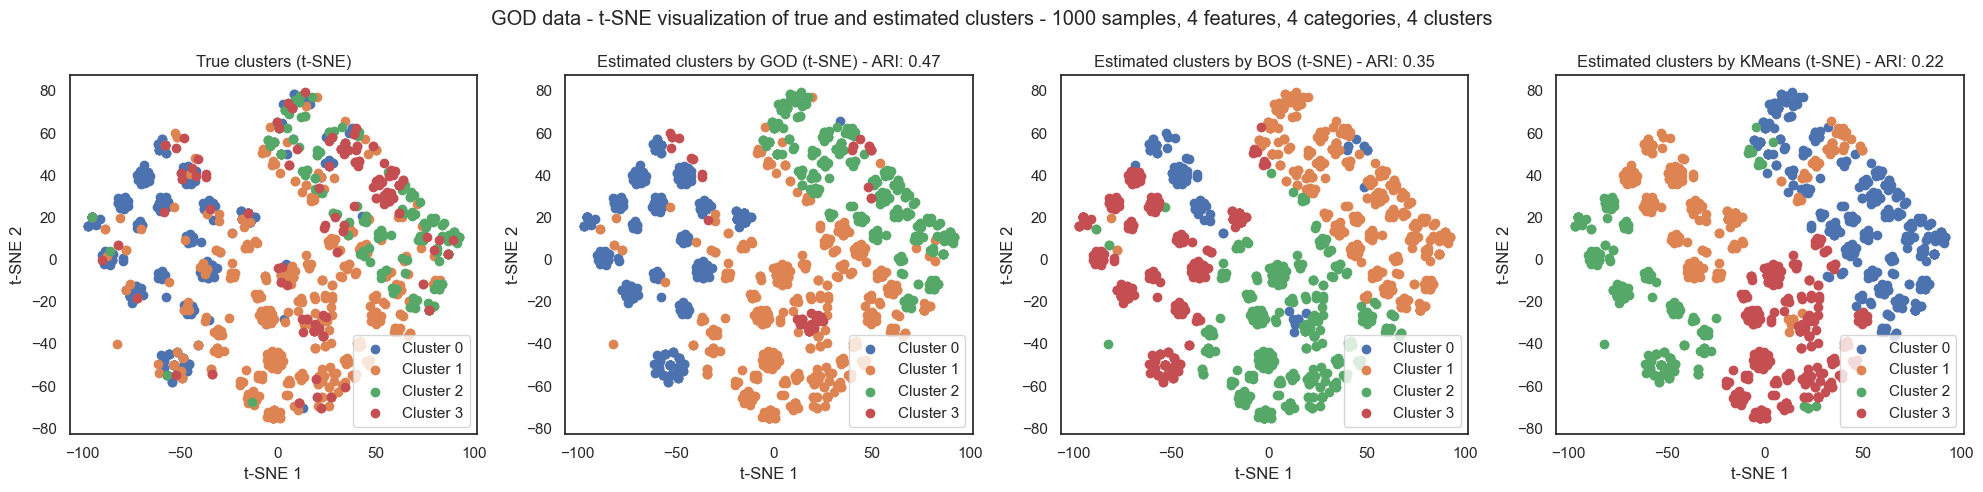

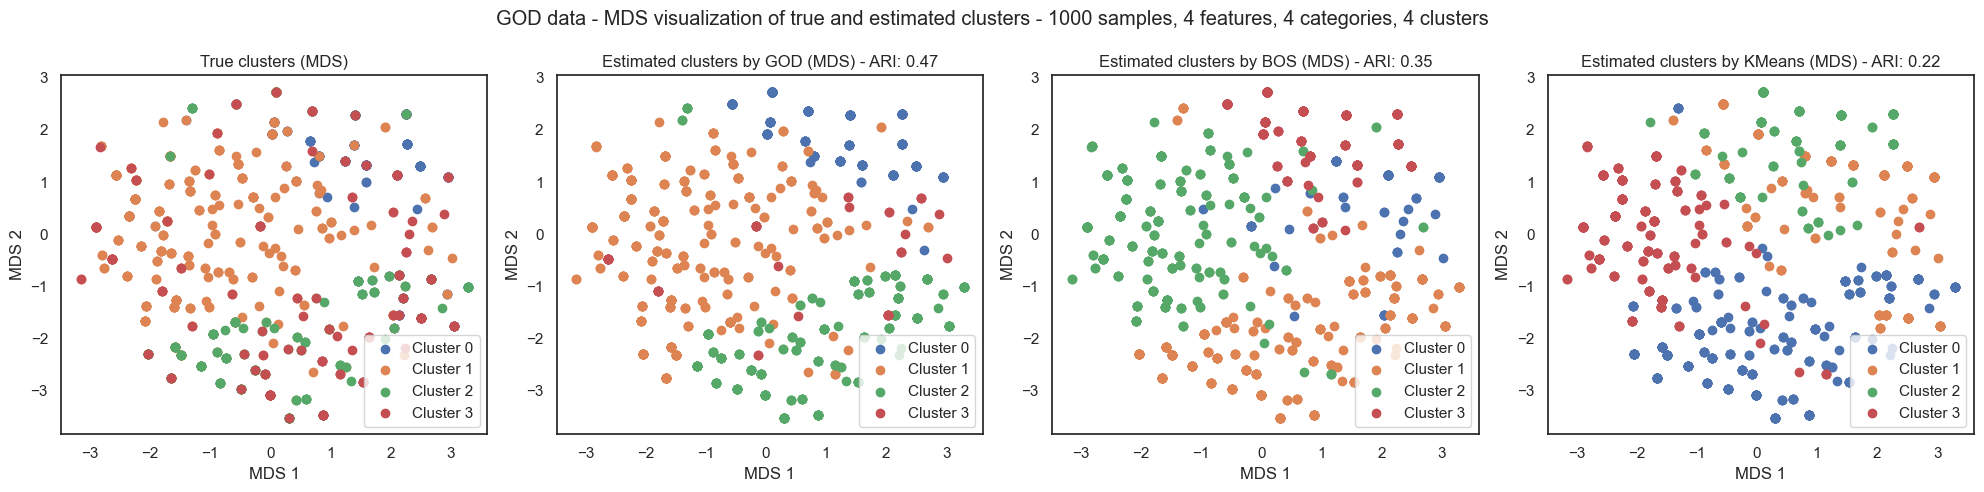

/Users/aliramlaoui/anaconda3/envs/ordinal_clustering/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


ARI GOD: 0.8395974432912479
ARI BOS: 0.7893864517012903
ARI KMeans: 0.4494180263138086


/Users/aliramlaoui/anaconda3/envs/ordinal_clustering/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


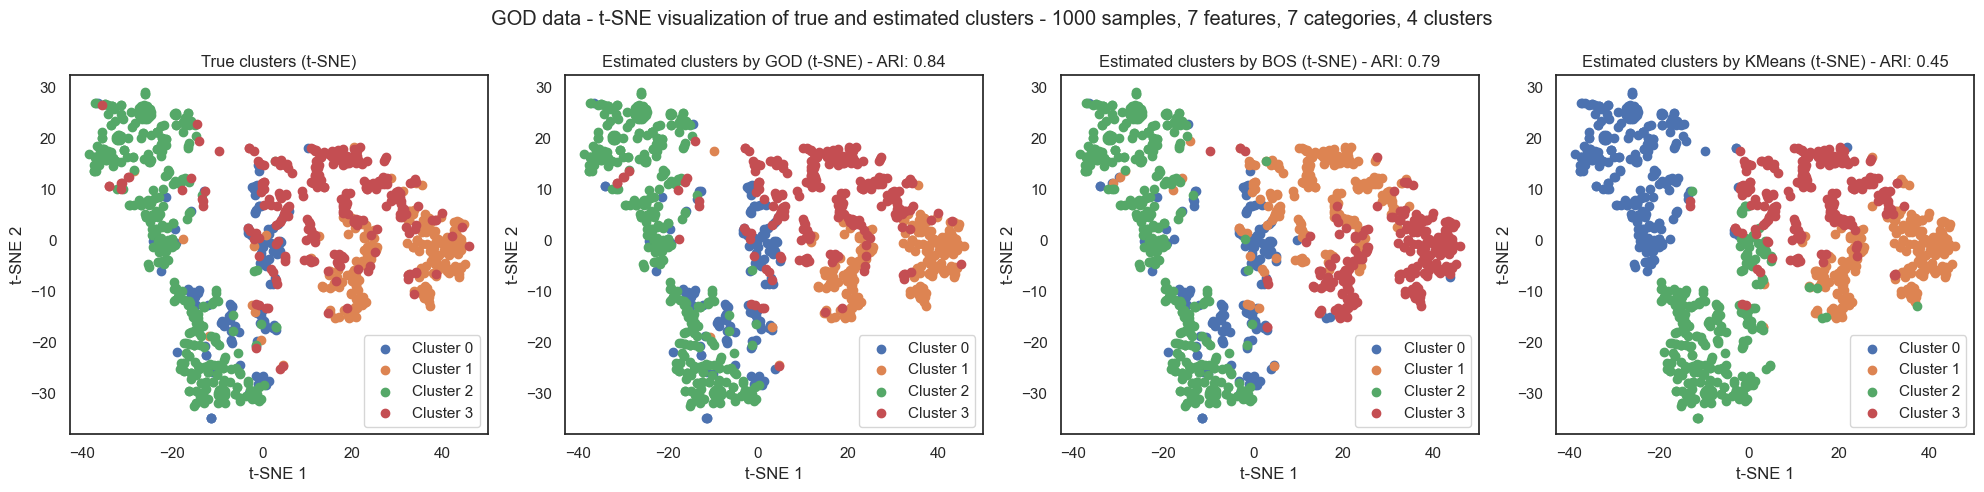

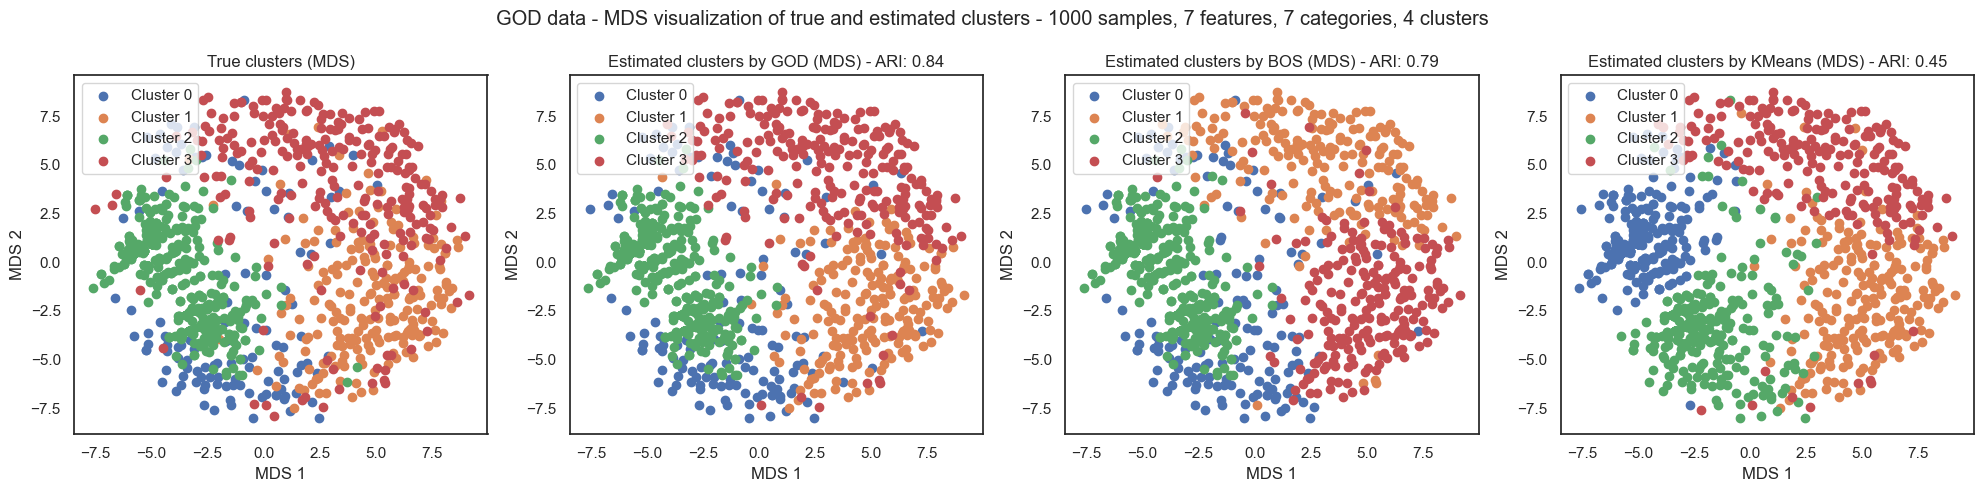

/Users/aliramlaoui/anaconda3/envs/ordinal_clustering/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


ARI GOD: 0.9475086534750705
ARI BOS: 0.9451704003992687
ARI KMeans: 0.6357670424182362


/Users/aliramlaoui/anaconda3/envs/ordinal_clustering/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


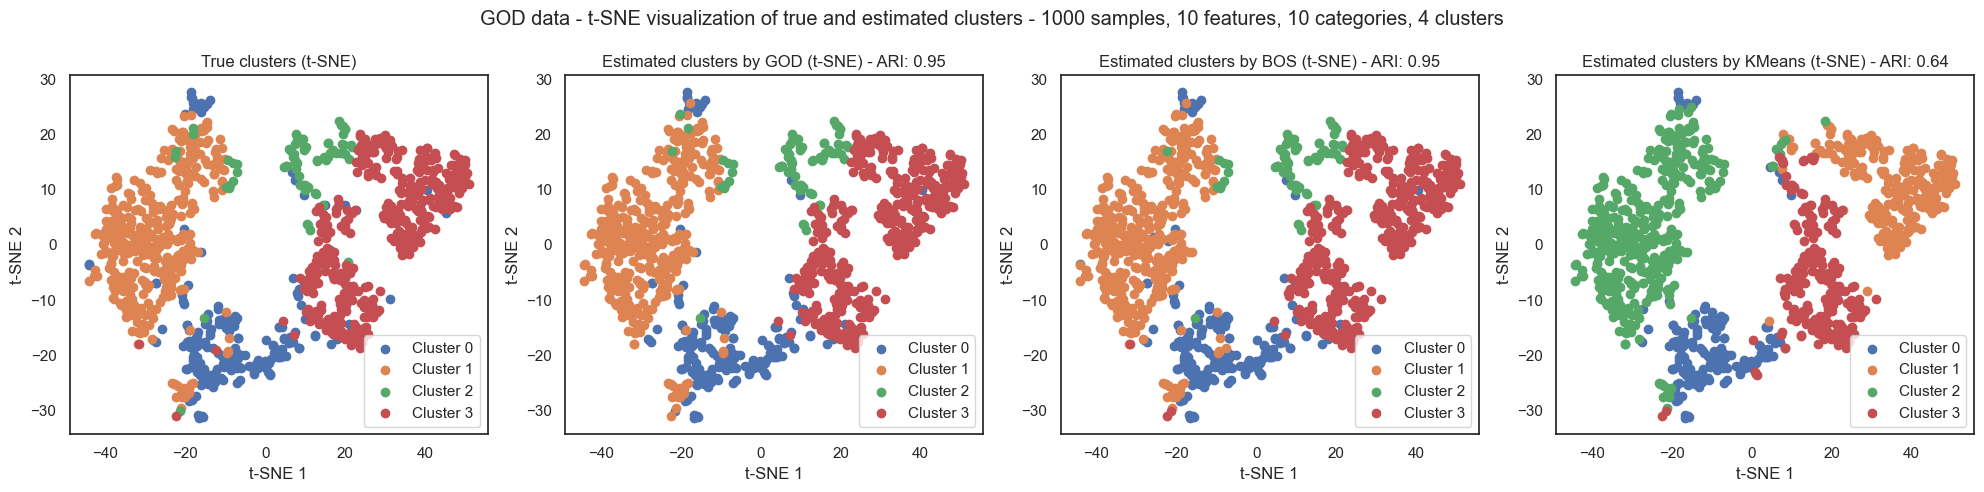

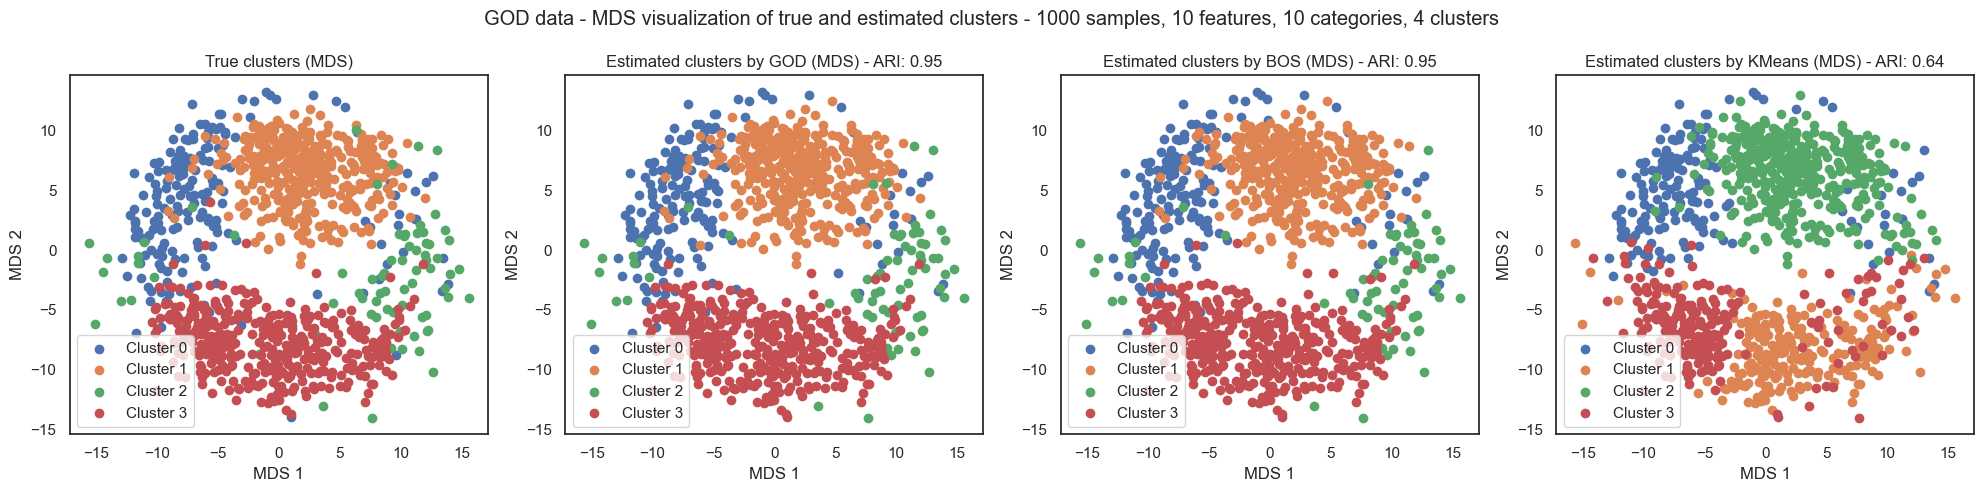

In [6]:
n = 1000
n_cluster = 4
ds = [4, 7, 10]
m_us = [4, 7, 10]

eps_aecm, n_iter = 1e-2, 200

seed = 3

data_model = "god"

for d, m_u in zip(ds, m_us):
    fig_tsne, ax_tsne = plt.subplots(1, 4, figsize=(20, 5))
    fig_mds, ax_mds = plt.subplots(1, 4, figsize=(20, 5))

    np.random.seed(seed)
    m = np.array([m_u] * d)
    mu = np.random.randint(np.ones(m.shape[0]), m + 1, (n_cluster, d))
    pi = np.random.random((n_cluster, d))

    # alpha = [1 / n_cluster] * n_cluster
    alpha = np.random.random(n_cluster)
    alpha = alpha / np.sum(alpha)

    X, y = generate_data(n, p=d, n_cat=m, k=n_cluster, alpha=alpha, mu=mu, pi=pi, seed=seed, model=data_model)

    clustering_god = AECM_GOD(nb_clusters=n_cluster,
                        nb_features=d,
                        ms=m,
                        data=X,
                        verbose=False,
                        seed=seed
                        )

    clustering_bos = AECM_BOS(nb_clusters=n_cluster,
                        nb_features=d,
                        ms=m,
                        data=X,
                        verbose=False,
                        seed=seed
                        )
                        
    ll_list_god = clustering_god.fit(epsilon_aecm=eps_aecm, max_iter_aecm=n_iter)

    ll_list_bos = clustering_bos.fit(epsilon_aecm=eps_aecm, max_iter_aecm=n_iter)

    labels_god = clustering_god.labels

    labels_bos = clustering_bos.labels

    kmeans = KMeans(n_clusters=n_cluster, random_state=seed)
    kmeans.fit(X)
    labels_kmeans = kmeans.labels_

    print(f"ARI GOD: {adjusted_rand_score(y, labels_god)}")
    print(f"ARI BOS: {adjusted_rand_score(y, labels_bos)}")
    print(f"ARI KMeans: {adjusted_rand_score(y, labels_kmeans)}")

    tsne = TSNE(n_components=2)
    X_tsne = tsne.fit_transform(X)


    def plot_tsne_mds(ax, X, y, title, type='t-SNE'):
        for i in range(np.unique(y).shape[0]):
            ax.scatter(X[y == i, 0], X[y == i, 1], label=f'Cluster {i}')
        ax.legend()
        ax.set_title(title)
        ax.set_xlabel(f'{type} 1')
        ax.set_ylabel(f'{type} 2')
        return ax
    
    plot_tsne_mds(ax_tsne[0], X_tsne, y, 'True clusters (t-SNE)', type='t-SNE')
    plot_tsne_mds(ax_tsne[1], X_tsne, labels_god, f'Estimated clusters by GOD (t-SNE) - ARI: {np.round(adjusted_rand_score(y, labels_god), 2)}', type='t-SNE')
    plot_tsne_mds(ax_tsne[2], X_tsne, labels_bos, f'Estimated clusters by BOS (t-SNE) - ARI: {np.round(adjusted_rand_score(y, labels_bos), 2)}', type='t-SNE')
    plot_tsne_mds(ax_tsne[3], X_tsne, labels_kmeans, f'Estimated clusters by KMeans (t-SNE) - ARI: {np.round(adjusted_rand_score(y, labels_kmeans), 2)}', type='t-SNE')

    mds = MDS(n_components=2, metric=True)
    X_mds = mds.fit_transform(X)

    plot_tsne_mds(ax_mds[0], X_mds, y, 'True clusters (MDS)', type='MDS')
    plot_tsne_mds(ax_mds[1], X_mds, labels_god, f'Estimated clusters by GOD (MDS) - ARI: {np.round(adjusted_rand_score(y, labels_god), 2)}', type='MDS')
    plot_tsne_mds(ax_mds[2], X_mds, labels_bos, f'Estimated clusters by BOS (MDS) - ARI: {np.round(adjusted_rand_score(y, labels_bos), 2)}', type='MDS')
    plot_tsne_mds(ax_mds[3], X_mds, labels_kmeans, f'Estimated clusters by KMeans (MDS) - ARI: {np.round(adjusted_rand_score(y, labels_kmeans), 2)}', type='MDS')

    fig_tsne.suptitle(f"GOD data - t-SNE visualization of true and estimated clusters - {n} samples, {d} features, {m_u} categories, {n_cluster} clusters")
    fig_mds.suptitle(f"GOD data - MDS visualization of true and estimated clusters - {n} samples, {d} features, {m_u} categories, {n_cluster} clusters")

    fig_tsne.tight_layout()
    fig_mds.tight_layout()

    fig_tsne.savefig(figures_path / f'tsne_god_n{n}_d{d}_m{m_u}_k{n_cluster}.png')
    fig_mds.savefig(figures_path / f'mds_god_n{n}_d{d}_m{m_u}_k{n_cluster}.png')

    plt.show()